In [1]:
import dolfinx.mesh as msh
import dolfinx.fem as fem
import mpi4py.MPI as mpi

import dolfinx.plot as dolplot
import ufl
import pyvista

import numpy as np
import petsc4py.PETSc as pet

In [2]:
import matplotlib.pyplot as plt

### Solve

In [3]:
domain= msh.create_unit_square ( mpi.COMM_WORLD,10,10, msh.CellType.quadrilateral )
space= fem.FunctionSpace(domain, ('CG',1))

In [4]:
u0_express=lambda x: 1 + x[0]**2 + 2 * x[1]**2
u0 = fem.Function(space)
u0.interpolate(u0_express);

In [5]:
spacedim= domain.topology.dim
domain.topology.create_connectivity(spacedim-1,spacedim)
bound_facet=msh.compute_boundary_facets(domain.topology)
bound_facet=np.flatnonzero(bound_facet)

In [6]:
bound_dofs = fem.locate_dofs_topological(space, spacedim - 1, bound_facet)
bc = fem.dirichletbc(u0, bound_dofs)

In [7]:
u = ufl.TrialFunction(space)
v = ufl.TestFunction(space)

In [8]:
f = fem.Constant(domain, np.float64(-6))

In [9]:
# Dot = ufl.dot
Dot=ufl.inner
Grad = ufl.grad
dx = ufl.dx


In [10]:
a = Dot(Grad(u), Grad(v)) *dx
L = f * v * dx

In [11]:
problem= fem.petsc.LinearProblem(a,L,bcs=[bc],petsc_options={"ksp_type": "preonly", "pc_type": "lu"})

In [12]:
uh = problem.solve()

### Error

In [13]:
space2=fem.FunctionSpace(domain,('CG',2))
u_extrapol=fem.Function(space2)
u_extrapol.interpolate(u0_express)

In [14]:
l2_error= fem.form(Dot(uh-u_extrapol,uh-u_extrapol)*dx)
error_local=fem.assemble_scalar(l2_error)
erorr_l2=np.sqrt(domain.comm.allreduce(error_local,op=mpi.SUM))

error_max= np.max(
    np.abs(u0.x.array-uh.x.array)
)
print(f'Error max: {error_max:.2e}')
print(f'Error: {erorr_l2:.2e}')

Error max: 2.66e-15
Error: 5.27e-03


### Visualise pyvista

In [15]:
u_topology, u_cell_types, u_geometry = dolplot.create_vtk_mesh(space)   
u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)

pyvista.set_jupyter_backend("pythreejs")
u_grid.point_data["u"] = uh.x.array.real
u_grid.set_active_scalars("u")
u_plotter = pyvista.Plotter()
u_plotter.add_mesh(u_grid, show_edges=True)
u_plotter.view_xy()

pyvista.OFF_SCREEN = False
if not pyvista.OFF_SCREEN:
    u_plotter.show()
else:
    pyvista.start_xvfb()
    figure = u_plotter.screenshot("fundamentals_mesh.png")    

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(DirectionalLight(intensity=0.25, positi…

In [16]:
if not pyvista.OFF_SCREEN:
    warped = u_grid.warp_by_scalar()
    plotter2 = pyvista.Plotter()
    plotter2.add_mesh(warped, show_edges=True, show_scalar_bar=True)
    plotter2.show(jupyter_backend="ipygany")

AppLayout(children=(VBox(children=(HTML(value='<h3>u</h3>'), Dropdown(description='Colormap:', options={'BrBG'…

In [17]:
from dolfinx import io
with io.VTKFile(domain.comm, "output.pvd", "w") as vtk:
    vtk.write([uh._cpp_object])
with io.XDMFFile(domain.comm, "output.xdmf", "w") as xdmf:
    xdmf.write_mesh(domain)
    xdmf.write_function(uh)

In [18]:
uh.x.array

array([1.  , 1.02, 1.01, 1.03, 1.08, 1.09, 1.04, 1.06, 1.18, 1.19, 1.12,
       1.09, 1.11, 1.32, 1.33, 1.22, 1.17, 1.16, 1.18, 1.5 , 1.51, 1.36,
       1.27, 1.24, 1.25, 1.27, 1.72, 1.73, 1.54, 1.41, 1.34, 1.33, 1.36,
       1.38, 1.98, 1.99, 1.76, 1.59, 1.48, 1.43, 1.44, 1.49, 1.51, 2.28,
       2.29, 2.02, 1.81, 1.66, 1.57, 1.54, 1.57, 1.64, 1.66, 2.62, 2.63,
       2.32, 2.07, 1.88, 1.75, 1.68, 1.67, 1.72, 1.81, 1.83, 3.  , 3.01,
       2.66, 2.37, 2.14, 1.97, 1.86, 1.81, 1.82, 1.89, 2.  , 2.02, 3.04,
       2.71, 2.44, 2.23, 2.08, 1.99, 1.96, 1.99, 2.08, 3.09, 2.78, 2.53,
       2.34, 2.21, 2.14, 2.13, 2.18, 3.16, 2.87, 2.64, 2.47, 2.36, 2.31,
       2.32, 3.25, 2.98, 2.77, 2.62, 2.53, 2.5 , 3.36, 3.11, 2.92, 2.79,
       2.72, 3.49, 3.26, 3.09, 2.98, 3.64, 3.43, 3.28, 3.81, 3.62, 4.  ])

### Visualise Matplot

In [22]:
u_topology, u_cell_types, u_geometry=dolplot.create_vtk_mesh(space) 
print(
len(u_geometry),
len(uh.x.array),
)

data=np.column_stack((u_geometry[:,0:2],uh.x.array))

121 121


ValueError: not enough values to unpack (expected 2, got 1)

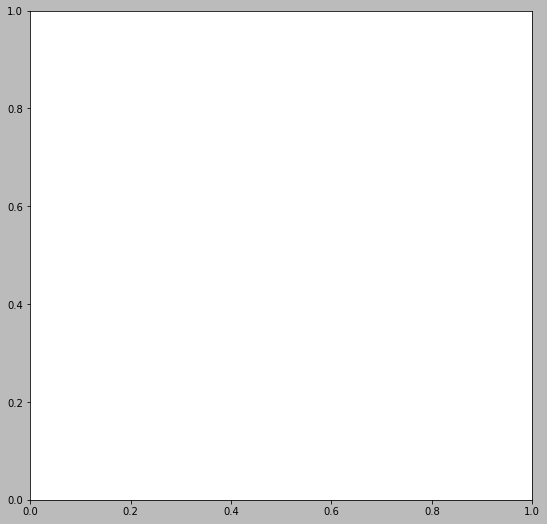

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(9, 9))
fig.set_facecolor('#BBB')
# ax.pcolormesh(data[:,0],data[:,1],data[:,2])
ax.pcolormesh([1,2,3],)


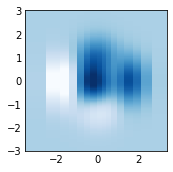

In [27]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('_mpl-gallery-nogrid')

# make data with uneven sampling in x
x = [-3, -2, -1.6, -1.2, -.8, -.5, -.2, .1, .3, .5, .8, 1.1, 1.5, 1.9, 2.3, 3]
X, Y = np.meshgrid(x, np.linspace(-3, 3, 128))
Z = (1 - X/2 + X**5 + Y**3) * np.exp(-X**2 - Y**2)

# plot
fig, ax = plt.subplots()

ax.pcolormesh(X, Y, Z, vmin=-0.5, vmax=1.0)

plt.show()